<a href="https://colab.research.google.com/github/TimothyBarao/Research-Projects/blob/main/RunPalmTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper title: Geometric properties of PalmTree instruction embeddings
## Target IJCNN, deadline: End of January


## **Overview**
*   Geometry of embeddings
*   Pairwise correlations
*   Find which are closer to which 
*   Analog relationship or outlier detection, see how embeddings relate different instructions
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search \

**Pairwise correlations** 
*   Correlations of the embeddings, plot them on histogram 
*   Relies on inner products between two vectors,

**Analyze** 
*   call, ret, mov, etc. most important instructions in malware analysis
*   Pick common instructions, look at embeddings see which ones are closer
*   Prediction "non of embeddings will be close/ will be perpendicular" 
*   Look at the vectors, for constants 0, 1, 2, etc. 

**Analog query** 
*   K nearest neighbors  
*   Look at vectors in  each layer, as input goes through, can see performance for analog query 
*   Find vector for king, minus vector for man + woman. find vector closest to this, see if result vector is close to king 
*   Outlier detection, look at each layer 

**Plot of embedding norms** 
*   Norm inverserly related to the frequency of tokens 
*   The most frequent tokens had smallest norm in Bert 

**For outliers, see accuracy of outliers from layer to layer**
*   Given sequence, see how it changes through the layers 
*   Look at number of layers in model 

**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   Figure out how to improve it, possible encod epair of instructions at a time

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   See if it improves 







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bert-pytorch

In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks/PalmTree-Trained/

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained


## Import and Load PalmTree model

In [3]:
import os
from config import *
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils


palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

# tokens has to be seperated by spaces.

text = ["mov rbp rdi", 
        "mov ebx 0x1", 
        "mov rdx rbx", 
        "call memcpy", 
        "mov [ rcx + rbx ] 0x0", 
        "mov rcx rax", 
        "mov [ rax ] 0x2e"]

# it is better to make batches as large as possible.
embeddings = palmtree.encode(text)
#for i in range(7):
#  print("usable embedding of this basicblock:", np.corrcoef(embeddings))
print("usable embedding of this basicblock:", np.linalg.norm(embeddings))

print("the shape of output tensor: ", embeddings.shape)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
usable embedding of this basicblock: 71.52081
the shape of output tensor:  (7, 128)


## Test Vocabulary

In [5]:
#Test Vocabulary
import vocab
import pickle
vocab_path = "./palmtree/vocab"
with open(vocab_path, "rb") as file:
  data = file.read()
  tokens = pickle.loads(data)
num_of_tokens = len(tokens)
print(tokens.to_seq(sentence="retn rbp 0x1"))
print(tokens.from_seq(seq=[5, 14, 19], join=True))

print(tokens.from_seq(seq=list(range(0,num_of_tokens)), join=False))

[68, 14, 28]
mov rbp rdi
['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'mov', '[', ']', 'rax', '+', 'qword', 'address', 'eax', 'rsp', 'rbp', 'rbx', 'symbol', 'rdx', 'call', 'rdi', '-', 'dword', 'add', 'rsi', 'rcx', 'cmp', 'je', '0x8', '0x1', 'test', 'edx', 'byte', 'r12', 'lea', 'jne', 'pop', '0x0', 'jmp', 'r13', 'r14', 'xor', 'r15', 'esi', 'ecx', 'edi', '0x10', '0x28', '0x18', 'al', 'movzx', '0x20', 'sub', 'rel', 'r8', 'and', 'ebx', 'push', '0x30', 'string', '*', '0x38', '0x4', 'ebp', 'r9', 'or', '0x48', '0x40', '0x2', 'retn', 'r8d', ':', 'shl', 'fs', 'r12d', 'r10', 'r9d', '8', 'r13d', '0x5', '0x3', 'cl', 'r14d', 'ja', 'dl', '0x58', '0x50', 'r15d', 'shr', '0x60', '0x68', 'r11', 'jbe', 'word', 'jae', '0x80', '0x70', '0xc', 'movsxd', 'xmm0', 'jb', '0x90', 'xmmword', '0x78', '0xffffffffffffffff', '0x100', 'nop', '0x88', 'r10d', '4', '0xf8', '0x98', 'imul', '0x14', '0x6', 'setne', 'sete', '0xb0', 'bl', 'r11d', '0xa', '2', 'ax', 'cmovne', 'cmove', '0xa8', '0x7', '0xa0', '0x1c', 'rep', 'not

## Correlation Coefficients of the Embeddings' Weights

BERTEmbedding(
  (token): TokenEmbedding(6631, 128, padding_idx=0)
  (position): PositionalEmbedding()
  (segment): SegmentEmbedding(3, 128, padding_idx=0)
  (dropout): Dropout(p=0.1, inplace=False)
)
[[ 1.        -0.0248631]
 [-0.0248631  1.       ]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53f4b23d90>]],
      dtype=object)

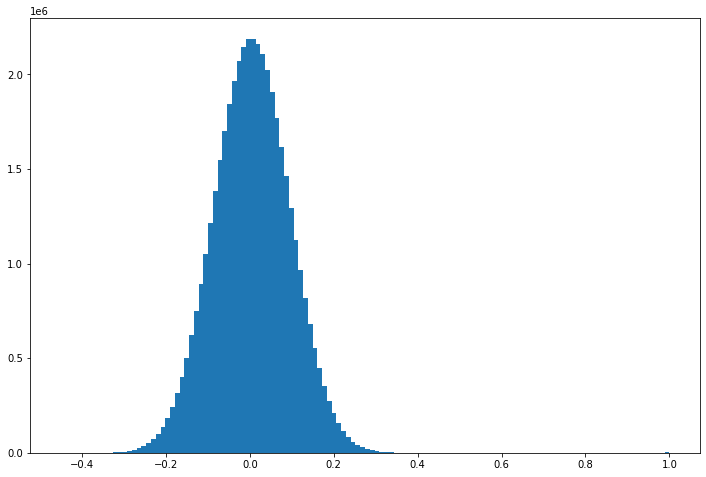

In [4]:
embedding_weights = palmtree.model.embedding
print(embedding_weights)
#Pair-wise Correlation
import pandas as pd

embedding_weights = pd.DataFrame(palmtree.model.embedding.token.weight.cpu().detach().numpy())

#for i in range(10):
#  print(np.linalg.norm(embedding_weights[i]))
print(np.corrcoef(embedding_weights[0], embedding_weights[1]))

df = pd.DataFrame(embedding_weights.transpose().corr().to_numpy().flatten())
df.columns = [""]
df.hist(bins=128, grid=False, figsize=(12,8))

## Pairwise Correlation(From Timothy's Notebook)

In [5]:
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()
df = pd.DataFrame(np.corrcoef(embedding_weights))

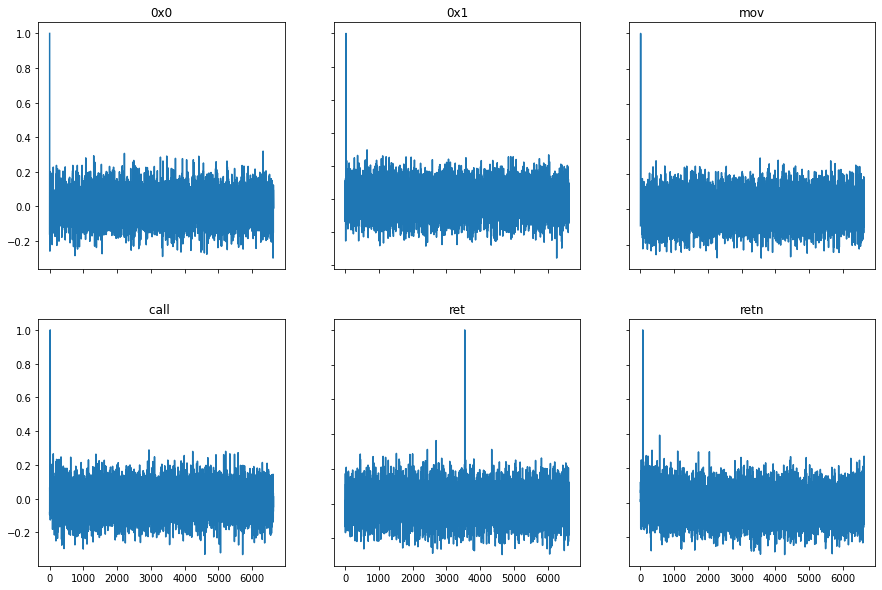

In [6]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

ax1.plot(df[0]), ax1.set_title("0x0")       # 0x0
ax2.plot(df[28]), ax2.set_title("0x1")      # 0x1
ax3.plot(df[5]), ax3.set_title("mov")       # mov
ax4.plot(df[18]), ax4.set_title("call ")    # call 
ax5.plot(df[3546]), ax5.set_title("ret")    # ret
ax6.plot(df[68]), ax6.set_title("retn")     # retn

for ax in fig.get_axes():
    ax.label_outer()  

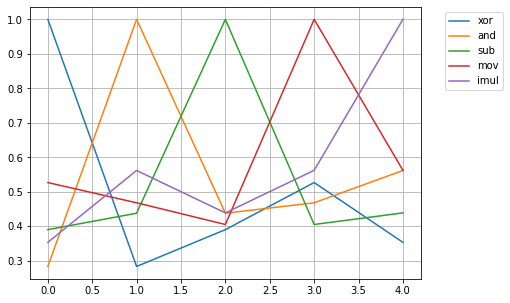

In [7]:
fig.clear()

# tokens have to be separated by spaces.
dataset = ["xor eax eax",
          "and 0x0 eax",
          "sub eax eax",
          "mov [eax] 0x0",
          "imul eax 0x0"]
output_tensor = palmtree.encode(dataset)

out = pd.DataFrame(np.corrcoef(output_tensor))
plt.figure(figsize=(7, 5))

plt.plot(out[0], label="xor")   # xor eax eax
plt.plot(out[1], label="and")   # and 0x0 eax
plt.plot(out[2], label="sub")   # sub eax eax
plt.plot(out[3], label="mov")   # mov [eax] 0x0
plt.plot(out[4], label="imul")  # imul eax 0x0

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

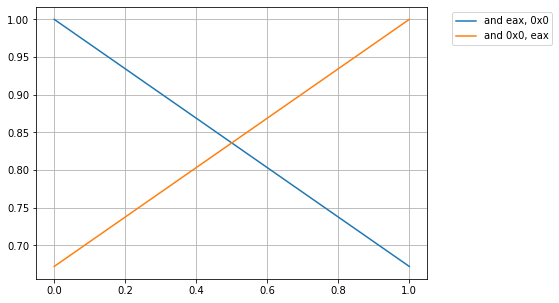

In [8]:
# tokens have to be separated by spaces.
dataset = ["and eax 0x0", 
           "and 0x0 eax"] # TODO: Change this, not valid x86
output_tensor = palmtree.encode(dataset)

out = pd.DataFrame(np.corrcoef(output_tensor))
plt.figure(figsize=(7, 5))

plt.plot(out[0], label="and eax, 0x0")   # and eax, 0x0
plt.plot(out[1], label="and 0x0, eax")   # and 0x0, eax

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

## Cosine Similarity (From Timothy's Notebook)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(embedding_weights)

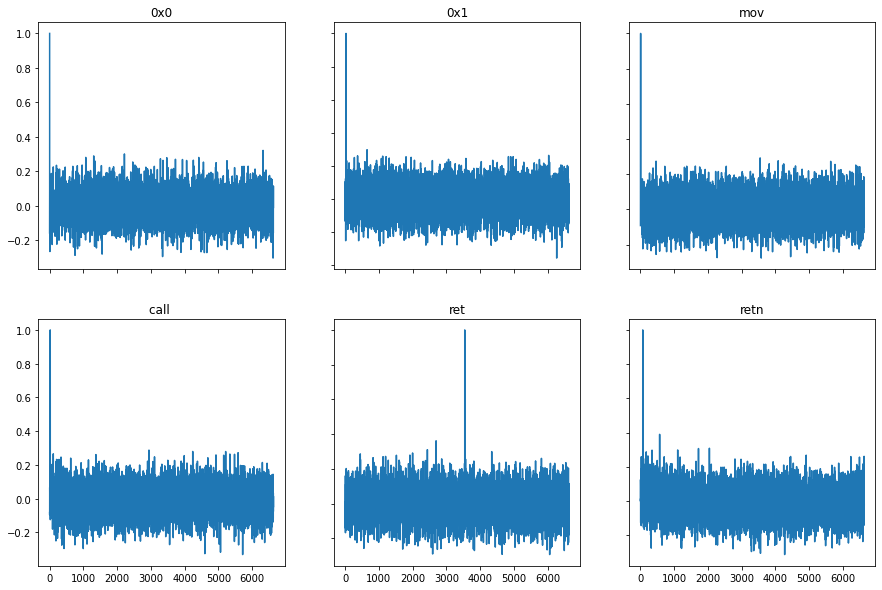

In [10]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

ax1.plot(cs[0]), ax1.set_title("0x0")       # 0x0
ax2.plot(cs[28]), ax2.set_title("0x1")      # 0x1
ax3.plot(cs[5]), ax3.set_title("mov")       # mov
ax4.plot(cs[18]), ax4.set_title("call ")    # call 
ax5.plot(cs[3546]), ax5.set_title("ret")    # ret
ax6.plot(cs[68]), ax6.set_title("retn")     # retn

for ax in fig.get_axes():
    ax.label_outer()   

## Datasets Used for Intrinsic Evaluation

In [7]:
import pickle

ground_truth_file = "intrinsic_eval/opcode.pkl"
with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

type(instruction_set)
for ins in instruction_set:
  print(ins, instruction_set[ins])
#print(instruction_set)

MOV {'mov,dword [ esp + 0x20 ],esi', 'mov,eax,dword [ esp + 0xa4 ]', 'mov,qword [ rsp + 0x98 ],r9', 'mov,eax,dword [ esp + 0x8 ]', 'mov,edx,0x3f', 'mov,eax,dword [ rbp - 0x340 ]', 'mov,rax,qword [ r12 + 0x8 ]', 'mov,dword [ ecx + 0x20 ],eax', 'mov,dword [ rbp - 0x3c4 ],address', 'mov,qword [ rbp - 0x388 ],rsi', 'mov,ecx,dword [ ebp - 0x1c ]', 'mov,rax,qword [ rax + 0x18 ]', 'mov,edi,dword [ rsp + 0x20 ]', 'mov,r12,r10', 'mov,byte [ eax + 0x6 ],dl', 'mov,r8,qword [ rbp - 0x3c8 ]', 'mov,r14,r8', 'mov,r9d,dword [ rbp - 0x310 ]', 'mov,eax,dword [ esi ]', 'mov,dword [ esp + 0x1c ],0x0', 'mov,dword [ r15 + 0x4 ],address', 'push,symbol', 'mov,byte [ rbp - 0x370 ],bl', 'mov,byte [ rsp + 0x55 ],0x0', 'mov,dword [ rsp + 0x8 ],0x20', 'mov,dword [ edi + 0x4 ],edx', 'mov,qword [ rax + 0x8 ],rdx', 'mov,dword [ ebp - 0x24 ],edx', 'mov,rsi,0x2e8ba2e8ba2e8ba', 'mov,dword [ ebp ],0x0', 'push,dword [ esp + 0xc ]', 'mov,edi,dword [ rbx ]', 'mov,qword [ r14 + 0x40 ],rbp', 'mov,ebx,dword [ r12 ]', 'mov,dwor

In [8]:
ground_truth_file = "intrinsic_eval/operand.pkl"
with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

for ins in instruction_set:
  print(ins, instruction_set[ins])

regreg {'sbb,ecx,edx', 'mov,r12,r10', 'cmp,rbx,r8', 'mov,r14,r8', 'test,bl,bl', 'sbb,esi,ecx', 'cmovbe,rdx,rdi', 'add,edx,eax', 'cmp,rsi,rdx', 'sub,rdx,r13', 'movsxd,rsi,r12d', 'mov,r11d,ebx', 'mov,r13d,ecx', 'mov,rcx,rbp', 'mov,r10d,r9d', 'sub,rbx,r14', 'sub,edi,eax', 'xor,edx,edx', 'sub,ecx,esi', 'mov,r13d,edx', 'mov,edx,r15d', 'cmp,rcx,r14', 'sub,r11,rax', 'or,r9d,edi', 'movsxd,rbx,ebx', 'cmovbe,r8,rcx', 'test,r14d,r14d', 'cmove,rax,rsi', 'or,rax,r12', 'sub,r9,r14', 'mov,r14,rbx', 'sub,edx,edi', 'test,r9,r9', 'and,rbp,rcx', 'movzx,edx,r12b', 'mov,rcx,r14', 'and,al,dil', 'sub,rdx,r8', 'mov,rdx,rsi', 'or,bl,al', 'movzx,r8d,r8b', 'cmova,r10,r8', 'add,rsi,r10', 'xor,eax,ecx', 'cmove,rbx,rbp', 'test,rdi,rdi', 'mov,edx,r9d', 'cmovb,rdi,r10', 'cmovne,eax,ecx', 'movaps,xmm3,xmm0', 'mov,r8d,r9d', 'cmp,ebx,edx', 'cmp,r15,r13', 'add,r10,r9', 'imul,r10,rcx', 'pxor,xmm1,xmm1', 'cvtsi2sd,xmm1,r12', 'cmova,rsi,rcx', 'cmp,rsi,rax', 'mov,rsi,r10', 'cmovne,esi,edx', 'add,rcx,rbx', 'movzx,eax,bl', 'te

In [9]:
ground_truth_file = "intrinsic_eval/mapping.pkl"
with open(ground_truth_file, 'rb') as f:
    basic_block_pairs = pickle.load(f)
type(basic_block_pairs)
#for bb in basic_block_pairs:
#  print(bb, basic_block_pairs[bb])

dict

## Outlier Detection Based on Opcode

In [12]:
#Run Evaluation Based on Opcode
#!python intrinsic_eval/eval_opcode.py
import os
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from multiprocessing.dummy import Pool as ThreadPool
from torch import nn

from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils
import re
import pickle

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def find_outliner(embeddings):
    result = pairwise_distances(embeddings, embeddings, metric='cosine')
    result = result.sum(axis=0)
    return np.argmax(result)

random.seed(time.time())
usable_model = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")
ground_truth_file = "./intrinsic_eval/opcode.pkl"

with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

result = []


def process(it):
    global result
    acc = 0
    i = 0
    while i < 100:
        outliner, inliner = random.sample(instruction_set.keys(), 2)
        out_pos = random.randint(0, 4)
        outliner = random.sample(instruction_set[outliner], 1)[0]
        operand = outliner.split(',')
        operand.pop(0) # pop out the opcode and compare the operands
        inliner_lst = []
        counter = 0
        while len(inliner_lst) < 4:
            choice = random.choice(list(instruction_set[inliner]))
            choice_operand = choice.split(',')
            choice_operand.pop(0)
            if choice_operand == operand: # compare operands, operands must be the same in our set.
                inliner_lst.append(choice)
            else:
                counter = counter+1
            if counter >= 5000:
                break
        
        if len(inliner_lst) < 4:
            # print("fail, choose another outlier")
            continue
        else:
            inliner = inliner_lst   
            inliner.insert(out_pos, outliner)
            inliner = [i.replace(",", " ")for i in inliner]
            embd = usable_model.encode(inliner)

            otlr = find_outliner(embd)

            if otlr == out_pos:
                acc += 1

        i+=1
    result.append(acc/100)

pool = ThreadPool()
pool.map(process, range(20))
pool.close()
pool.join()


with open('op_palmtree.pkl', 'wb') as f:
    pickle.dump(result, f)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631


# Proposal: Teaching Malware Analysis students
**Write proposal to help students do software reverse engingeering** 
*   Education, not research 
*   Help students

*   Give function students need to analyze
*   Help student understand function by itself
*   Ghidra can generate the C Code, can it compile?
*   Isolate, where it calls another function, replace with placeholder
 *   Do not symbolically call another function
*   CFG, go down path and then back up?
*   **Find out how to provide the different cases for the function**
*   **How to go from symbolic execution, go to higher level semantics. i.e determine cases and give examples**
*   Use symbion instead of placeholder, and use concrete execution and provide values
*   Target common problems, not complex issues
*   Use binaries from the malware book

# Proposal: NLP describe functions
*   Use Microsoft API DLL, find description form web or binary itself
 *   Create Dataset to learn
*   Given a new function, generate a Natural language description of the function    


Combine what we learn from PalmTree Analysis, and try to solve problems others have done but better

Use embeddings to encode a program

# Further Readings & References

**Papers to read**
*   Neutron: https://cybersecurity.springeropen.com/articles/10.1186/s42400-021-00070-0
*   Geometry of Bert: http://vigir.missouri.edu/~gdesouza/Research/Conference_CDs/IEEE_WCCI_2020/IJCNN/Papers/N-21493.pdf
* PalmTree: https://arxiv.org/pdf/2103.03809.pdf
* Blanket Execution: https://www.usenix.org/system/files/conference/usenixsecurity14/sec14-paper-egele.pdf 